In [25]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data 
df = pd.read_csv("../data/Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# checking NA 
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [4]:
# remove outlier if any 
def remove_outliers_iqr_all(df):
    numeric_cols = df.select_dtypes(include='number').columns
    mask = pd.Series([True] * len(df), index=df.index)  

    for col in numeric_cols:
        data = df[col].dropna()
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        mask &= (df[col] >= lower) & (df[col] <= upper)

    return df[mask]  
df = remove_outliers_iqr_all(df)
print("Before cleaning", df.shape)
print("After cleaning", df.shape)

Before cleaning (198, 5)
After cleaning (198, 5)


In [5]:
# pick just the numerical columns becaues the model is accepting only numerical data
df = df.select_dtypes(include=['float64', 'int64'])

In [6]:
df

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,2,21,15,81
2,3,20,16,6
3,4,23,16,77
4,5,31,17,40
...,...,...,...,...
193,194,38,113,91
194,195,47,120,16
195,196,35,120,79
196,197,45,126,28


In [9]:
# The model is sensitive to feature scales, so we should scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [10]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

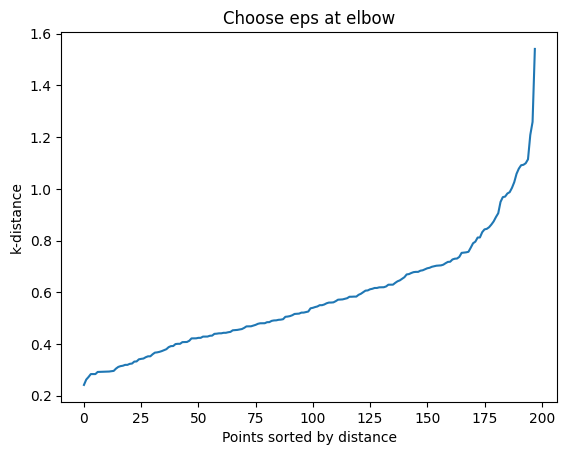

In [11]:
plt.plot(distances)
plt.ylabel("k-distance")
plt.xlabel("Points sorted by distance")
plt.title("Choose eps at elbow")
plt.show()

In [12]:
# Train DBSCAN (set eps after elbow analysis)
# db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=-1)
 # labels = db.fit_predict(X_scaled)

In [33]:
# Function to evaluate DBSCAN with different parameters
def evaluate_dbscan(X, eps_values, min_samples_values):
    results = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            # Ensure min_samples is integer
            min_samples = int(min_samples)
            
            db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
            labels = db.fit_predict(X)
            
            # Number of clusters (ignoring noise if present)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            
            # Calculate silhouette score (only if more than 1 cluster)
            if n_clusters > 1:
                try:
                    silhouette = silhouette_score(X, labels)
                except:
                    silhouette = -1  # Handle cases where silhouette can't be calculated
            else:
                silhouette = -1  # Invalid score
            
            # Count noise points
            noise_points = list(labels).count(-1)
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'silhouette': silhouette,
                'noise_points': noise_points
            })
    
    return pd.DataFrame(results)


In [34]:
eps_values = np.linspace(0.3, 1.0, 8)
min_samples_values = [3, 5, 7, 10]
param_results = evaluate_dbscan(X_scaled, eps_values, min_samples_values)
print("\nParameter evaluation results:")
print(param_results.sort_values('silhouette', ascending=False).head(10))



Parameter evaluation results:
    eps  min_samples  n_clusters  silhouette  noise_points
14  0.6            7           5    0.218470            59
13  0.6            5           6    0.216126            40
19  0.7           10           2    0.210535            64
9   0.5            5           6    0.182104            76
12  0.6            3           5    0.170391            17
18  0.7            7           4    0.162323            35
23  0.8           10           2    0.153750            35
8   0.5            3          12    0.138377            42
15  0.6           10           5    0.096325            93
16  0.7            3           2    0.088806            11


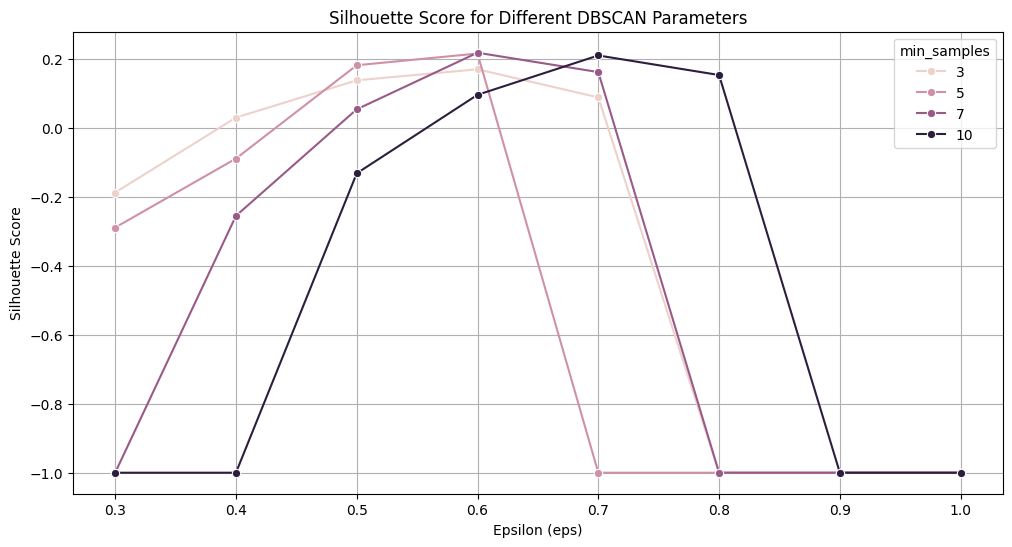

In [35]:
# Visualize parameter performance
plt.figure(figsize=(12, 6))
sns.lineplot(data=param_results, x='eps', y='silhouette', hue='min_samples', marker='o')
plt.title('Silhouette Score for Different DBSCAN Parameters')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [36]:
best_params = param_results.loc[param_results['silhouette'].idxmax()]
print("\nBest parameters:")
print(best_params)



Best parameters:
eps              0.60000
min_samples      7.00000
n_clusters       5.00000
silhouette       0.21847
noise_points    59.00000
Name: 14, dtype: float64


In [38]:
# Train DBSCAN with best parameters
best_db = DBSCAN(eps=best_params['eps'], 
                min_samples=int(best_params['min_samples']),  # Convert to int
                metric='euclidean')
labels = best_db.fit_predict(X_scaled)

In [39]:
# Add labels to dataframe
df['Cluster'] = labels

In [40]:
df

,CustomerID,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,19,15,39,-1
1,2,21,15,81,0
2,3,20,16,6,-1
3,4,23,16,77,0
4,5,31,17,40,-1
...,...,...,...,...,...
193,194,38,113,91,-1
194,195,47,120,16,-1
195,196,35,120,79,-1
196,197,45,126,28,-1


In [41]:
df["Cluster"].value_counts()

Cluster
-1    59
 1    51
 3    32
 2    27
 0    19
 4    10
Name: count, dtype: int64

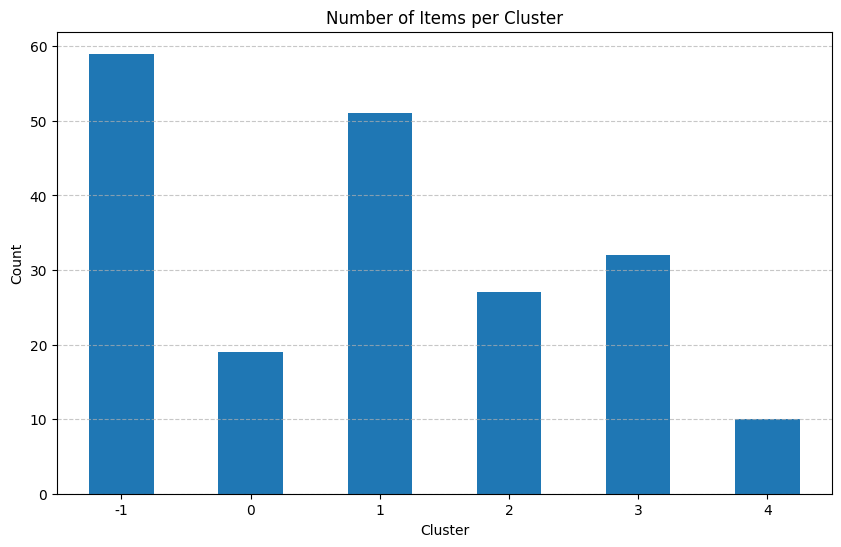

In [42]:
import matplotlib.pyplot as plt

# Count the number of items in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

# Create bar plot
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.title('Number of Items per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()